The Jupyter Book is [here](https://geo-smart.github.io/oceanography/intro.html).


The GitHub repo is [here](https://github.com/geo-smart/oceanography).


## The OOI RCA Shallow Profiler


This notebook introduces physical and bio-optical data from the Ocean Observatories 
Initiative (***OOI***) Regional Cabled Array (***RCA***) *Shallow Profiler*, shown below. 
These platforms are anchored to the sea floor by cables. They are positively buoyant
and are parked at a depth of 200 meters where they continuously record sensor data. 
By means of a cable/winch they regularly profile (sample) the upper 200 meters of the 
water column, hence the name shallow profiler.


Some further detail on how data are collected: The bulbous pod in the photo below 
(called the Science Pod or SCIP) is attached to the moored rectangular platform 
by means of the yellow cable. The profiler ascends and then descends nine times per day.
Multiple instruments are visible, bolted to the SCIP, where each instrument bears
one or more sensors. Hence the sensors correspond to types of data: Temperature, 
chlorophyll fluorescence and so on. 



<BR>
<img src="./../../img/shallowprofilerinsitu.png" style="float: left;" alt="drawing" width="400"/>
<div style="clear: left"><BR>


Photo taken by the Remotely Operated Vehicle (ROV) "Ropos" at a depth of 200 meters.

### Technical note

There are two types of data we are concerned with here: Sensor data and profile metadata. 
The sensor data from the profiler are viewed in relation to depth, hence 'profile charts'. 
In order to generate these we need to know when the profiler is starting and ending 
an ascent; as well as a descent and a rest period when it is parked on the platform
at 200 meters.


Profile metadata is read using the function `ReadProfileMetadata(filename)` where the filename
describes the site and the time period of interest. The data are held in a pandas Dataframe.


The data structure `sensors` is a list of 2-element lists. The first element is a sensor name
and the second is the corresponding instrument that carries the sensor. 


`sensors[3] = ['salinity', 'ctd']`


The data structure `ranges` is a dictionary of expected upper and lower bounds for each sensor.
The keys are sensor names as found in `sensors`; values are tuples.


`ranges['salinity'] = (31, 35)`


The data structure `standard_deviations` is a dictionary of standard deviation ranges, also tuples.


`standard_deviations['salinity'] = (.0, .4)`


The data structure `colors` is a dictionary of colors associated with sensors in charts.


`colors['salinity'] = 'cyan'`


The data structure `sensor_names` is a dictionary of expanded sensor names more suited
to chart labels.


`sensor_names['salinity'] = 'Salinity'`

In [1]:
from shallowprofiler import *
from charts import *

# profiles is a pandas DataFrame treated as a global resource 
profiles = ReadProfileMetadata('../profiles/osb_profiles_jan22.csv')


Jupyter Notebook running Python 3


## Objective: Build a data dictionary **`d`** for a given site and month


The next step is to build a data dictionary **`d `** with keys corresponding to sensors:
**`conductivity`, `temperature`, `pco2`** etcetera. The corresponding value for each sensor
key is a five-tuple indexed \[0\], \[1\], ..., \[4\].


```
0: XArray DataArray: sensor data
1: XArray DataArray: sensor depth (meters, negative down) corresponding to data
2: float: Default charting lower limit for data
3: float: Default charting upper limit for data
4: string: Default chart color e.g. "blue"
```

Note that if the time extent of the data is one month -- say 30 days -- 
a healthy shallow profiler will generate about $9 \times 30 = 270$ profiles.
Selecting out time blocks that correspond to these profiles is done using
the profile metadata, contained in the dataframe called `profiles`. 

In [2]:
# Spectral irradiance did not quite align so this code breaks out the
#   channels into separate .nc files. 
def ReformatSpkirData(ds, output_fnm_base):
    """
    From an un-differentiated spkir.nc source file we have Dataset ds.
    This will be written as 7 sensor files where sensor name is spkir412nm etc.
    Already using non-duplicated 'time'. Sensor names will have spkir pre-pended.
    """
    ds_data_vars = [i for i in ds.data_vars]
    ds_attrs     = [i for i in ds.attrs]
    dvars = [['412nm', 'spkir412nm'],      # [0] becomes [1]
             ['443nm', 'spkir443nm'], ['490nm', 'spkir490nm'], ['510nm', 'spkir510nm'],
             ['555nm', 'spkir555nm'], ['620nm', 'spkir620nm'], ['683nm', 'spkir683nm']]

    for dv in dvars:                 # loops over data variables to modify 
        local_ds = ds.copy()         #   the local_ds copy of the passed full dataset
        for ds_dv in ds_data_vars:
            if not ds_dv == dv[0] and not ds_dv == 'z':
                local_ds = local_ds.drop(ds_dv)
            elif ds_dv == dv[0]:
                local_ds = local_ds.rename({ds_dv:dv[1]})
        for key in ds_attrs: 
            if not key == 'units': local_ds.attrs.pop(key)

        # double check: eliminate duplicated time entries
        _, keeper_index = np.unique(local_ds['time'], return_index=True)
        local_ds = local_ds.isel(time=keeper_index)
        
        write_fnm = output_fnm_base + dv[1] + '.nc'
        local_ds.to_netcdf(write_fnm)
    return

##############
# 
# This code adjusts spkir data files by breaking them out into wavelength channels.
#   It is confusing because an input file e.g. osb_spkir_jan22_spkir.nc has already
#   been generated by ReformatDataFile() found in data.py. 
#
##############
relative_path = './../data/'
site          = 'osb'
instrument    = 'spkir'
sensor        = 'spkir'
spkir_months  = ['apr21', 'jul21', 'jan22']
if False: 
    for month in spkir_months:
        input_fnm       = relative_path + site + '_' + instrument + '_' + month + '_' + sensor + '.nc'
        output_fnm_base = relative_path + site + '_spkir_' + month + '_'
        ds = xr.open_dataset(input_fnm)
        ReformatSpkirData(ds, output_fnm_base)

# run this to verify
# ds = xr.open_dataset('./../data/osb_spkir_jan22_spkir412nm.nc')
# ds.spkir412nm.plot()

In [3]:
d = {}

relative_path = './../data/'
sitestring = 'osb'                    # available: osb = Oregon Slope Base
monthstring = 'jan22'                 # available: apr21, jul21, jan22

# error: apr21 and jul21 seem to fail on pCO2 despite data files present

def AssembleDataFilename(relative_path, site, instrument, time, sensor): 
    return relative_path + site + '_' + instrument + '_' + time + '_' + sensor + '.nc'

def GetSensorTuple(s, f):
    '''
    s is the sensor identifier string like 'temperature'
    f is the source filename like './../data/osb_ctd_jan22_temperature.nc' 
    '''
    df_sensor    = xr.open_dataset(f)[s]
    df_z         = xr.open_dataset(f)['z']
    range_lo     = ranges[s][0]
    range_hi     = ranges[s][1]
    sensor_color = colors[s]
    return (df_sensor, df_z, range_lo, range_hi, sensor_color)

for sensor in sensors:          # sensor is a list of 2 strings [sensor_str, instrument_str]
    f = AssembleDataFilename(relative_path, sitestring, sensor[1], monthstring, sensor[0])
    d[sensor[0]] = GetSensorTuple(sensor[0], f)

In [4]:
# diagnostic fossil
# for a in list(d['pco2'][0].attrs.keys()): del d['pco2'][0].attrs[a]
# for a in list(d['pco2'][1].attrs.keys()): del d['pco2'][1].attrs[a]
# d['pco2'][0]

In [5]:
# Start with CTD temperature and salinity
how_many_charts = 12

# quick check: use d['temperature'].z.plot()
profile_list = [n for n in range(how_many_charts)]

#### Using the ChartTwoSensors() function


The following cells create plots for many sensor types using the ChartTwoSensor() comparative chart
generator. The passed arguments make use of the data dictionary d{} established above. The keys are
the short version sensor names such as 'do' and '412nm' and 'nitrate'. The values are 5-ples so they
are indexed as \[0\], \[1\], ..., \[4\]:

Data dictionary value = (
                          DataArray: sensor data values, dimension = 'time'   \[0\]
                          DataArray: sensor depths z,    dimension = 'time'   \[1\] 
                          low-end expected data range                         \[2\]
                          high-end expected data range                        \[3\]
                          color for this sensor                               \[4\] 
                        )
                          



Attempting 12 charts



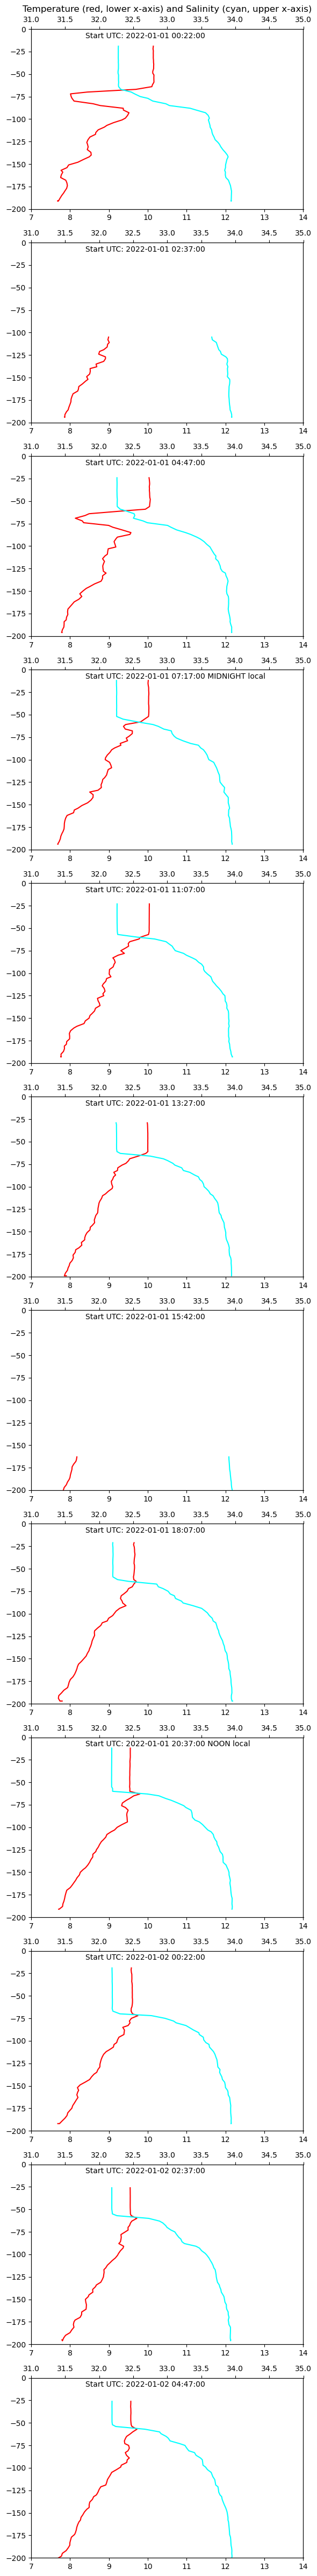

In [6]:
# temperature and salinity
fig,axs = ChartTwoSensors(profiles, [ranges['temperature'], ranges['salinity']], profile_list, 
                          d['temperature'][0], d['temperature'][1], 'Temperature', colors['temperature'],    'ascent',
                          d['salinity'][0],       d['salinity'][1],    'Salinity',  colors['salinity'], 'ascent', 6, 4)

Attempting 12 charts



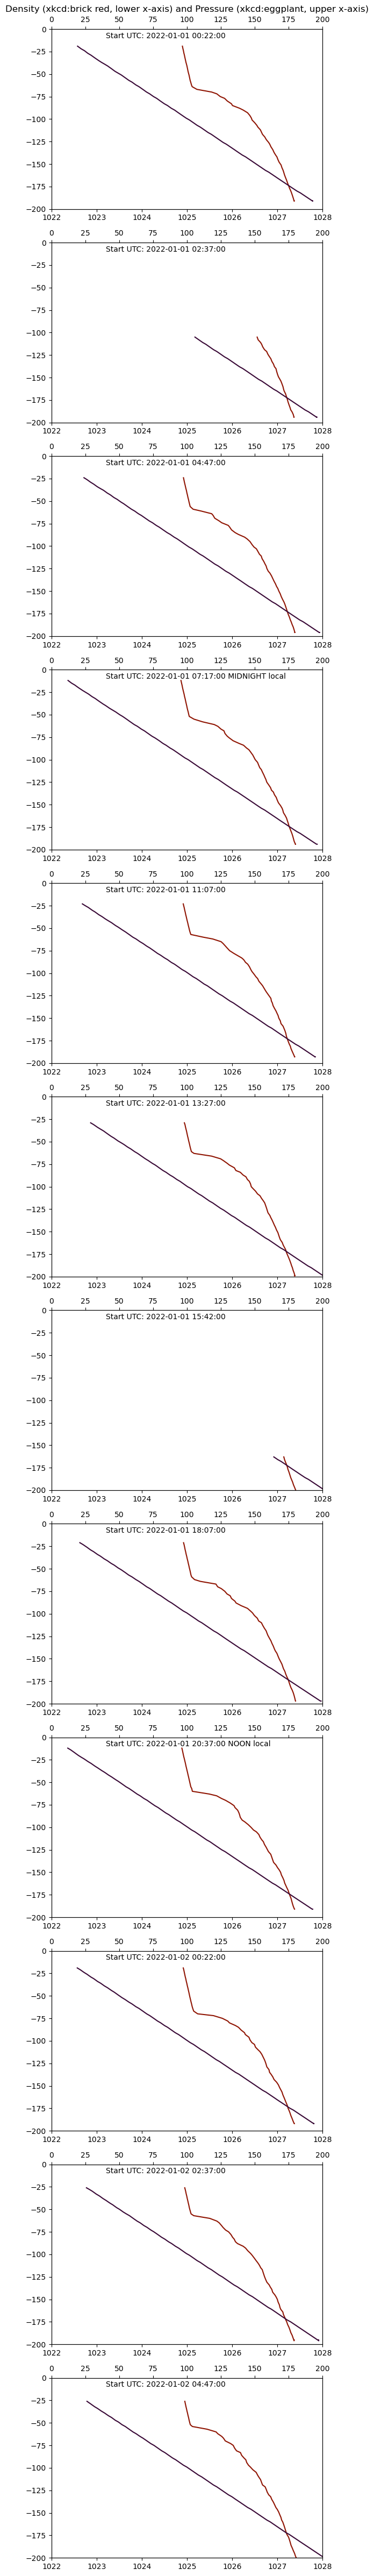

In [7]:
# density and pressure
fig,axs = ChartTwoSensors(profiles, [ranges['density'], ranges['pressure']], profile_list, 
                          d['density'][0], d['density'][1], 'Density', colors['density'],    'ascent',
                          d['pressure'][0],       d['pressure'][1],    'Pressure',  colors['pressure'], 'ascent', 6, 4)

Attempting 12 charts



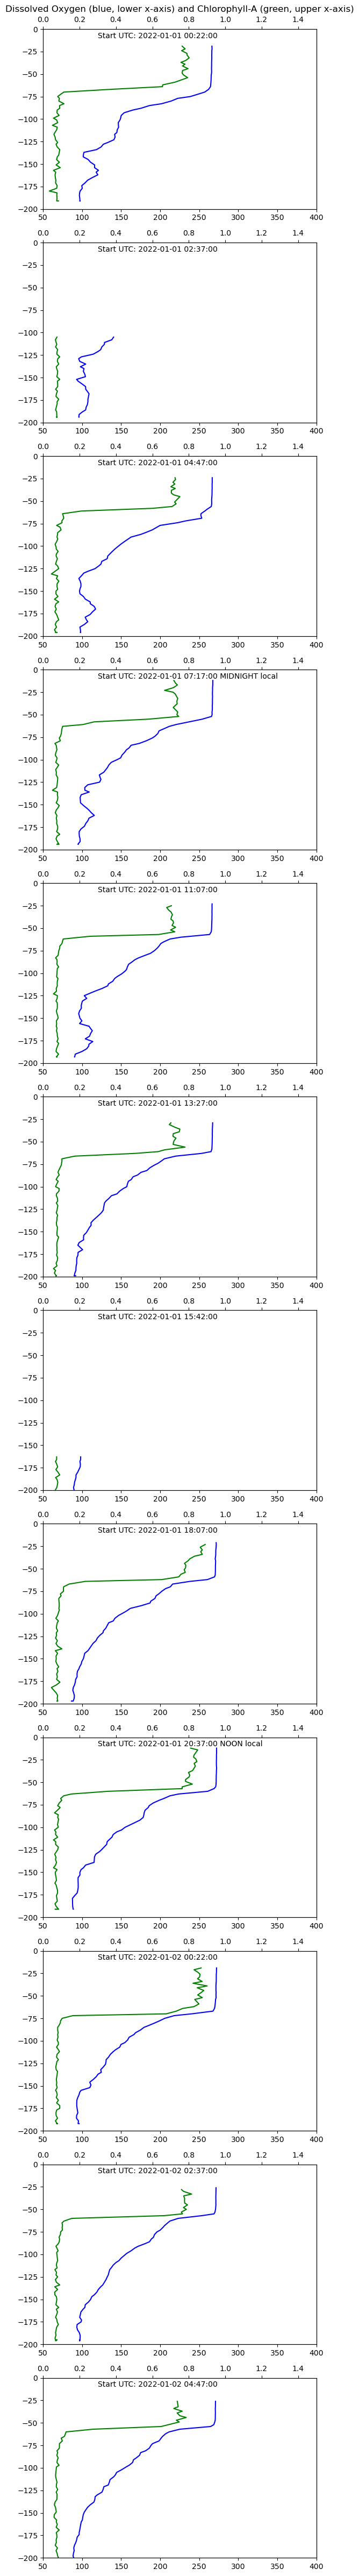

In [8]:
# dissolved oxygen and chlorophyll-a
fig,axs = ChartTwoSensors(profiles, [ranges['do'], ranges['chlora']], profile_list, 
                          d['do'][0], d['do'][1], 'Dissolved Oxygen', colors['do'],    'ascent',
                          d['chlora'][0],       d['chlora'][1],    'Chlorophyll-A',  colors['chlora'], 'ascent', 6, 4)

Attempting 12 charts



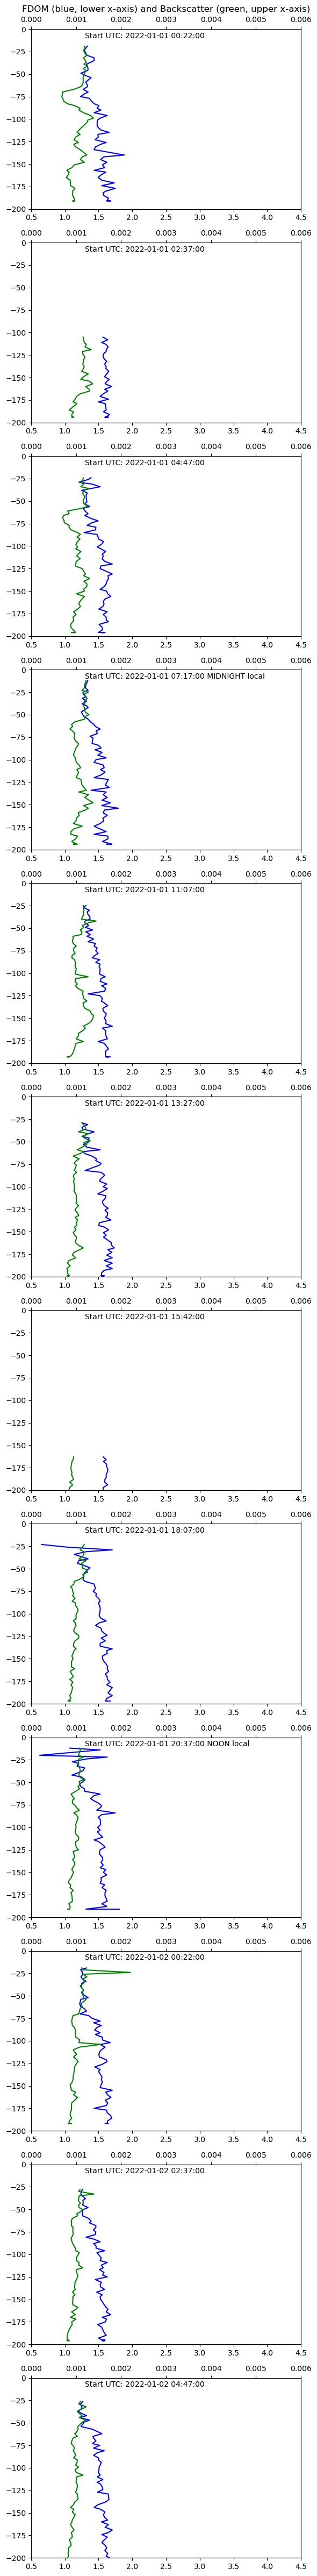

In [9]:
# fdom and backscatter
fig,axs = ChartTwoSensors(profiles, [ranges['fdom'], ranges['bb']], profile_list, 
                          d['fdom'][0], d['fdom'][1], 'FDOM', colors['do'], 'ascent',
                          d['bb'][0], d['bb'][1], 'Backscatter', colors['chlora'], 'ascent', 6, 4)

Attempting 3 charts



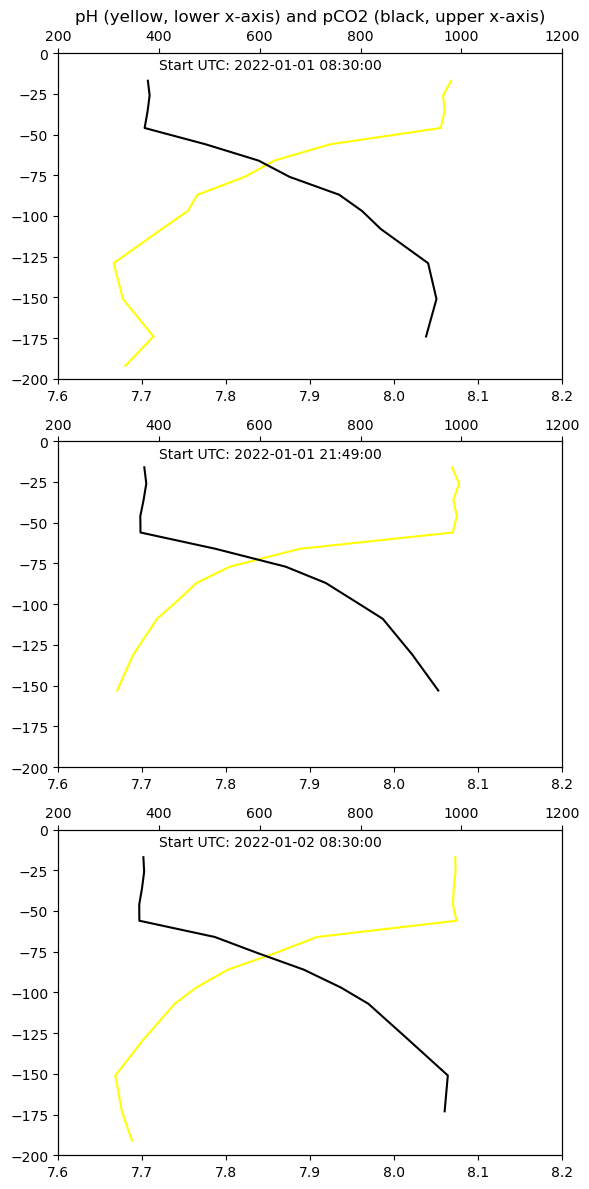

In [10]:
# pH and pCO2
# Notice that pH and pCO2 are measured only on midnight and noon *descents*
#   Profile 3 is the first midnight profile, 8 the first noon (but labels need fixing)
fig,axs = ChartTwoSensors(profiles, [ranges['ph'], ranges['pco2']], [3, 8, 12],
                          d['ph'][0], d['ph'][1], 'pH', colors['ph'], 'descent',
                          d['pco2'][0], d['pco2'][1], 'pCO2', colors['pco2'], 'descent', 6, 4)

Attempting 2 charts



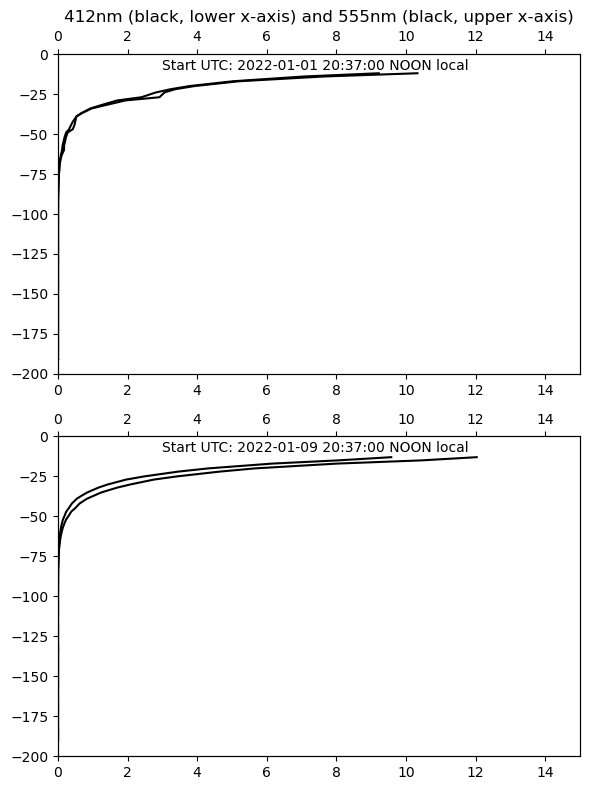

In [13]:
# Two good representatives of noon spectral irradiance
fig,axs = ChartTwoSensors(profiles, [ranges['spkir412nm'], ranges['spkir555nm']], [8, 80],
                          d['spkir412nm'][0], d['spkir412nm'][1], '412nm', colors['spkir412nm'], 'ascent',
                          d['spkir555nm'][0], d['spkir555nm'][1], '555nm', colors['spkir555nm'], 'ascent', 6, 4)


Attempting 2 charts



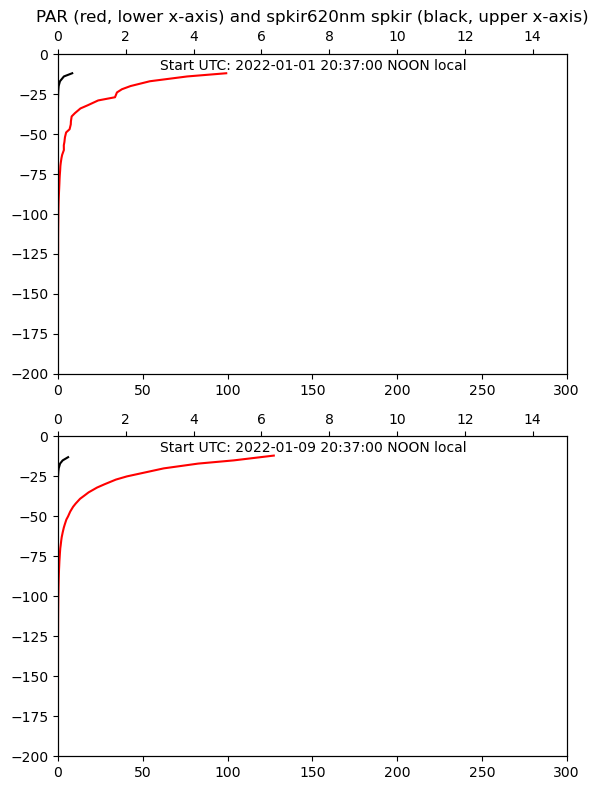

In [15]:
# PAR and longer-wavelength spectral irradiance (not a very strong signal; see above)
fig,axs = ChartTwoSensors(profiles, [ranges['par'], ranges['spkir620nm']], [8, 80],
                          d['par'][0], d['par'][1], 'PAR', colors['par'], 'ascent',
                          d['spkir620nm'][0], d['spkir620nm'][1], 'spkir620nm spkir', 
                          colors['spkir620nm'], 'ascent', 6, 4)

Attempting 3 charts



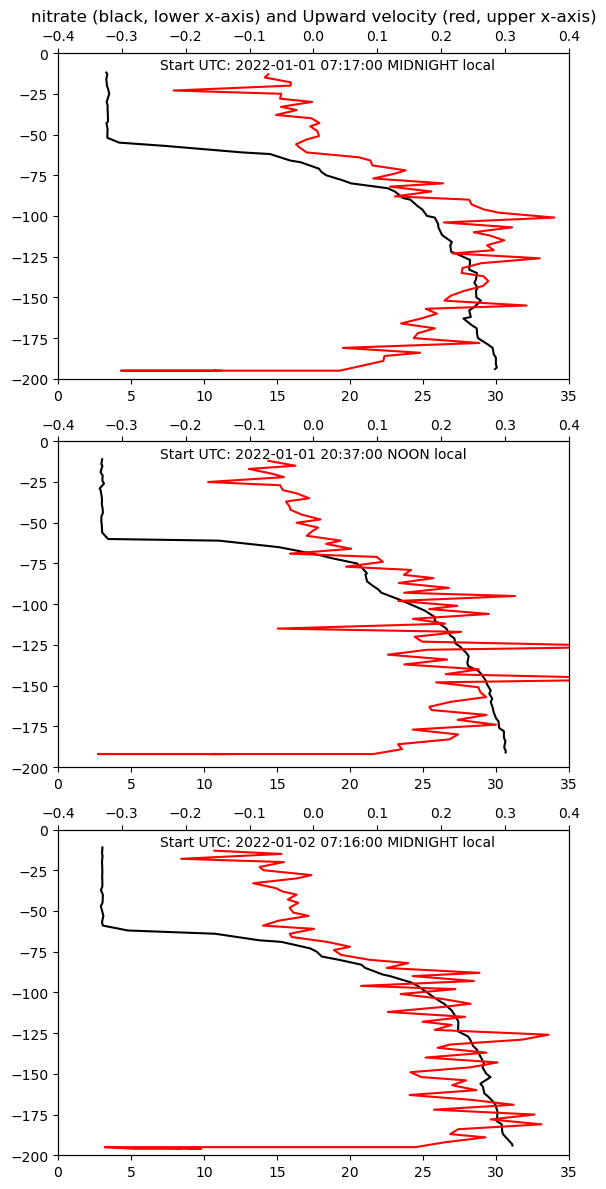

In [16]:
# Nitrate and current velocity 'up' (midnight and noon: ascent for nitrate)
fig,axs = ChartTwoSensors(profiles, [ranges['nitrate'], ranges['up']], [3, 8, 12],
                          d['nitrate'][0], d['nitrate'][1], 'nitrate', colors['nitrate'], 'ascent',
                          d['up'][0], d['up'][1], 'Upward velocity', colors['up'], 'ascent', 6, 4)

Attempting 12 charts



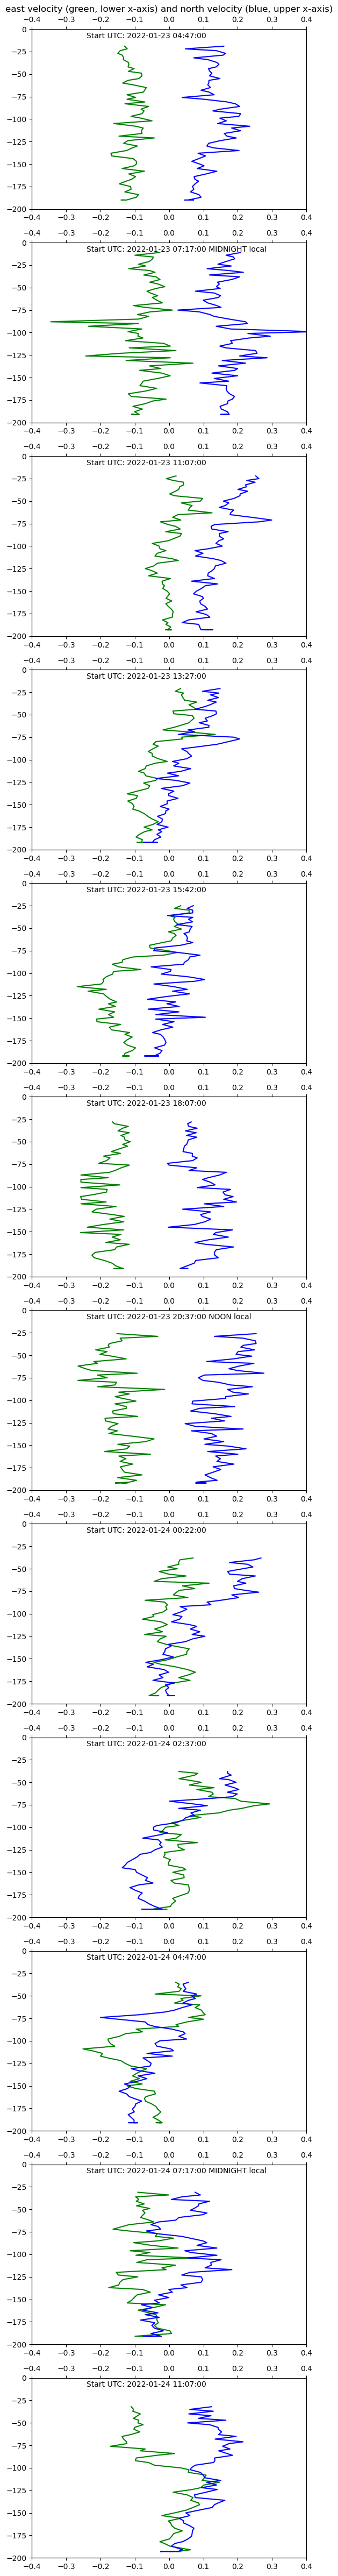

In [17]:
how_many_current_charts = 12
first_current_chart = 200
profile_list = [n for n in range(first_current_chart, first_current_chart + how_many_current_charts)]
# Current velocity 'east' and 'north'
fig,axs = ChartTwoSensors(profiles, [ranges['east'], ranges['north']], profile_list,
                          d['east'][0], d['east'][1], 'east velocity', colors['east'], 'ascent',
                          d['north'][0], d['north'][1], 'north velocity', colors['north'], 'ascent', 6, 4)

## Summary so far


The material above demonstrates charting most available sensors. In some cases this relies upon
careful selection of relevant profiles and profile phases (ascent versus descent). 


Next: Ensemble views of data via *bundle charts*.



## Bundle charts


A bundle chart overlays consecutive sensor profiles. These are static; the further section
is interactive.

In [18]:
def GenerateTimeWindowIndices(date0, date1, time0, time1):
    '''
    In UTC: Define a time box from two bounding days and -- within a day -- 
    a bounding time interval. This function then produces a list of profile 
    indices for profiles that begin ascent within the time box. These indices
    refer to the rows in the profiles DataFrame

    date0       define the time box in the [date0, date1] sense
    date1
    time0       likewise inclusive [time0, time1] sense
    time1
    
    profiles is a global variable (DataFrame)
    '''
    global profiles

    pidcs = []
    for i in range(len(profiles)):
        a0 = profiles["a0t"][i]
        if a0 >= date0 and a0 <= date1 + td64(1, 'D'):
            delta_t = a0 - dt64(a0.date())
            if delta_t >= time0 and delta_t <= time1: pidcs.append(i)
    return pidcs

In [19]:
def BundleChart(date0, date1, time0, time1, wid, hgt, data, title):
    '''
    Create a bundle chart: Multiple profiles showing sensor/depth in ensemble.
        date0   start / end of time range: date only, range is inclusive [date0, date1]
        date1
        time0   start / end time range for each day
        time1       (this scheme permits selecting midnight or noon)
        wid     figure size
        hgt
        data    a value from the data dictionary (5-tuple: includes range and color)
        title   chart title
        
    profiles is a global DataFrame
    '''
    pidcs = GenerateTimeWindowIndices(date0, date1, time0, time1) # each index contributes a thread to the bundle
    fig, ax = plt.subplots(figsize=(wid, hgt), tight_layout=True)
    for i in range(len(pidcs)):
        ta0, ta1 = profiles["a0t"][pidcs[i]], profiles["a1t"][pidcs[i]]          # [ta0, ta1] is this thread's time range (ascent)
        ax.plot(data[0].sel(time=slice(ta0,  ta1)), data[1].sel(time=slice(ta0, ta1)), ms = 4., color=data[4], mfc=data[4])
    ax.set(title = title)
    ax.set(xlim = (data[2], data[3]), ylim = (-200, 0))
    return ax

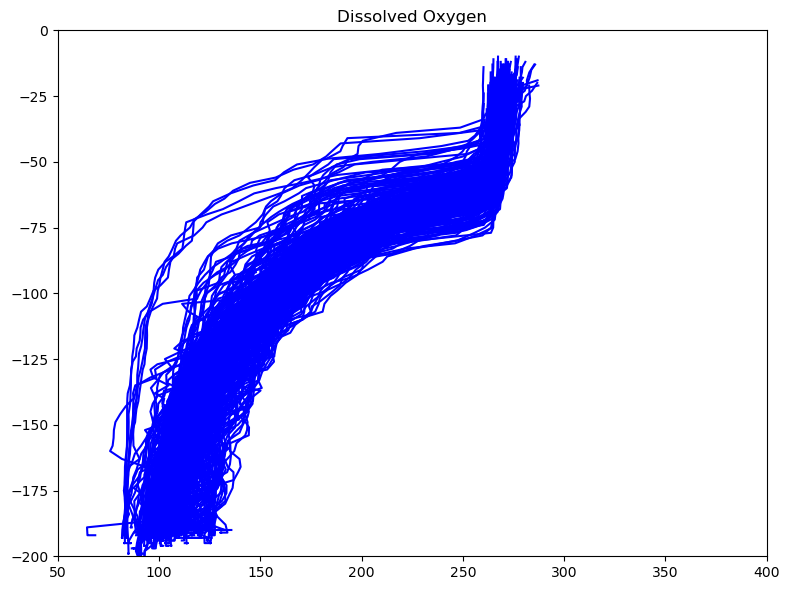

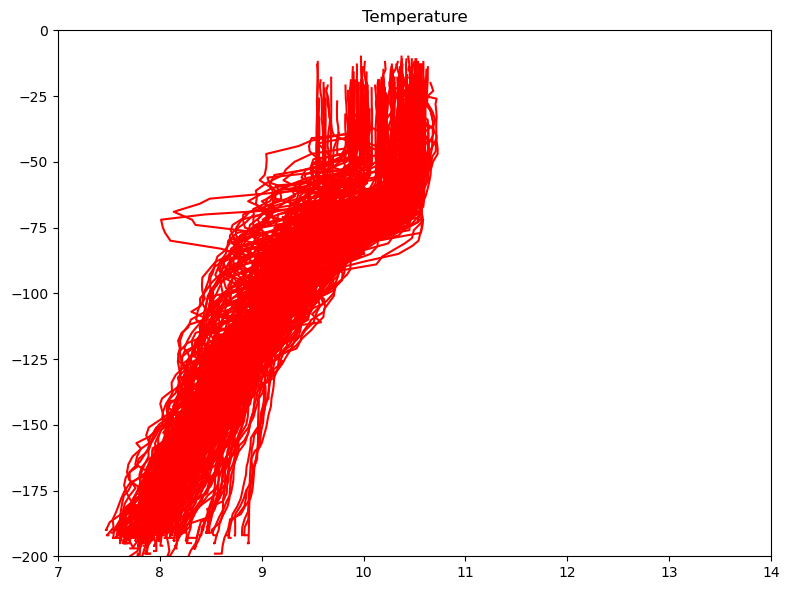

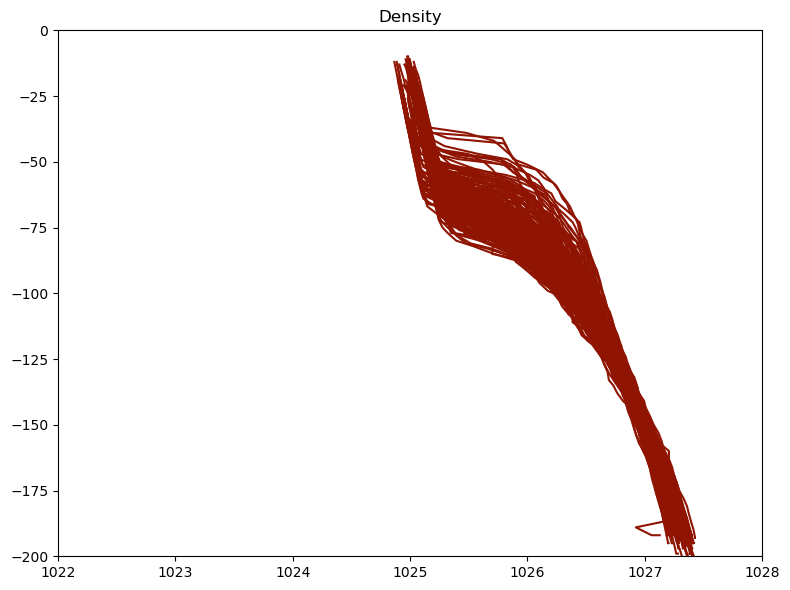

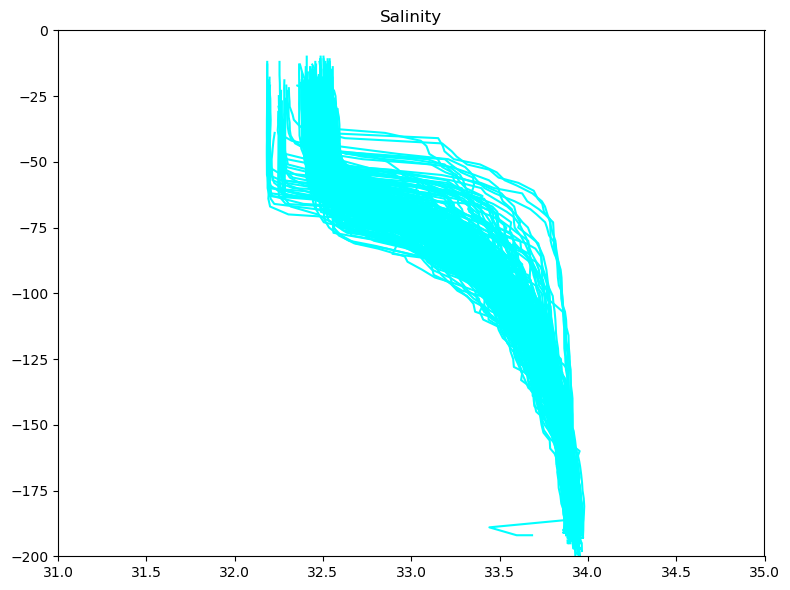

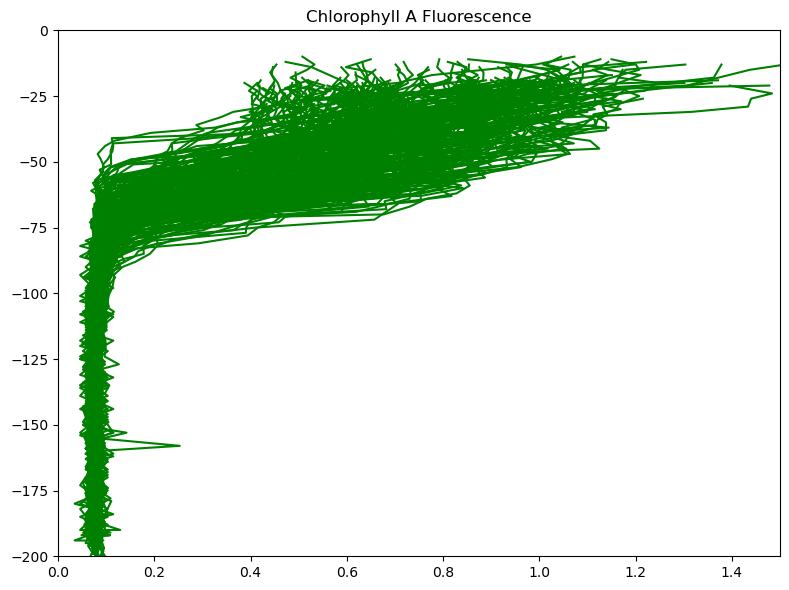

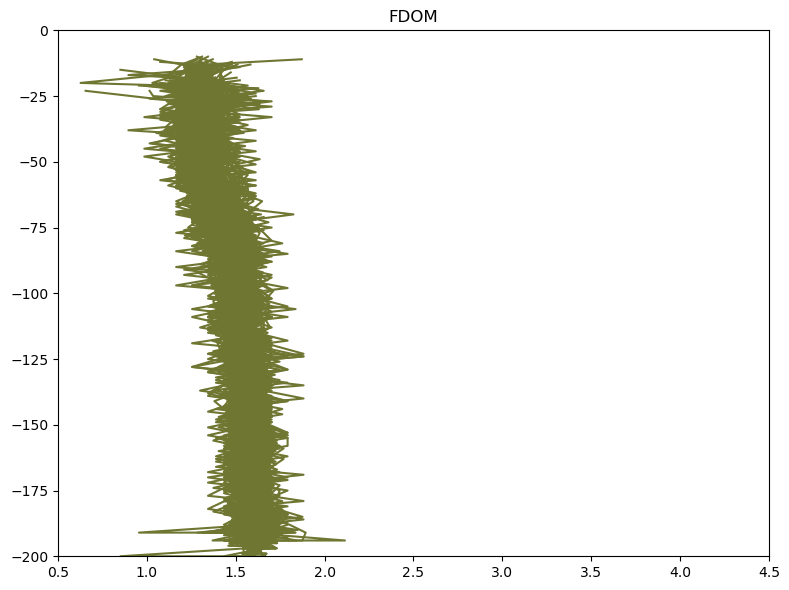

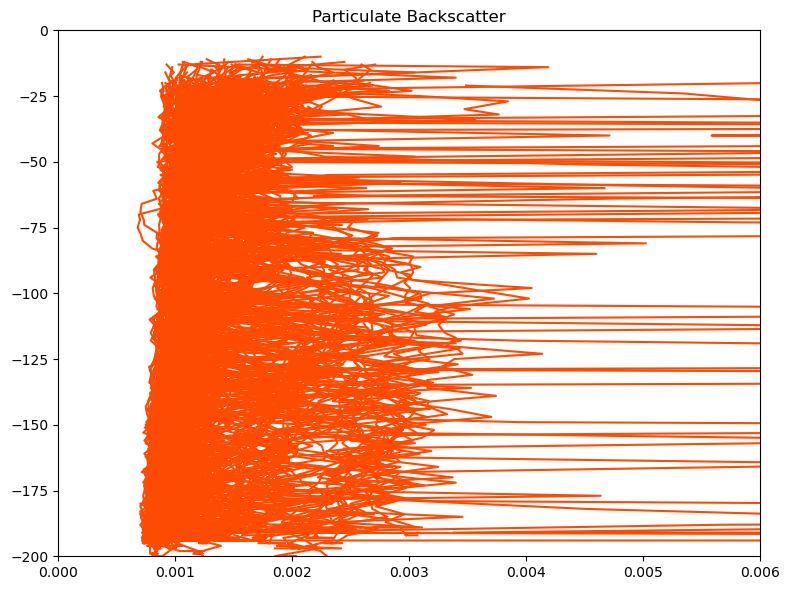

In [20]:
def ShowStaticBundles():
    '''creates bundle charts for Jan 2022, Oregon Slope Base'''
    BundleChart(dt64('2022-01-01'), dt64('2022-02-01'), td64(0, 'h'), td64(24, 'h'), 8, 6, d['do'], 'Dissolved Oxygen')
    BundleChart(dt64('2022-01-01'), dt64('2022-02-01'), td64(0, 'h'), td64(24, 'h'), 8, 6, d['temperature'], 'Temperature')
    BundleChart(dt64('2022-01-01'), dt64('2022-02-01'), td64(0, 'h'), td64(24, 'h'), 8, 6, d['density'], 'Density')
    BundleChart(dt64('2022-01-01'), dt64('2022-02-01'), td64(0, 'h'), td64(24, 'h'), 8, 6, d['salinity'], 'Salinity')
    BundleChart(dt64('2022-01-01'), dt64('2022-02-01'), td64(0, 'h'), td64(24, 'h'), 8, 6, d['chlora'], 'Chlorophyll A Fluorescence')
    BundleChart(dt64('2022-01-01'), dt64('2022-02-01'), td64(0, 'h'), td64(24, 'h'), 8, 6, d['fdom'], 'FDOM')
    BundleChart(dt64('2022-01-01'), dt64('2022-02-01'), td64(0, 'h'), td64(24, 'h'), 8, 6, d['bb'], 'Particulate Backscatter')
    
    return

ShowStaticBundles()

In [21]:
from ipywidgets import interact, widgets
from traitlets import dlink

In [22]:
def BundleInteract(sensor_key, time_index, bundle_size):
    '''
    Consider a time range that includes many (e.g. 279) consecutive profiles. This function plots sensor data
    within the time range. Choose the sensor using a dropdown. Choose the first profile using the start slider.
    Choose the number of consecutive profiles to chart using the bundle slider. 
    Details
      - There is no support at this time for selecting midnight or noon profiles exclusively
          - nitrate, ph and pco2 bundle charts will be correspondingly sparse
      - There is a little bit of intelligence built in to the selection of ascent or descent
          - most sensors measure on ascent or ascent + descent. pco2 and ph are descent only
          - ph and pco2 still have a charting bug "last-to-first line" clutter: For some reason
            the first profile value is the last value from the prior profile. There is a hack in
            place ("i0") to deal with this.
    '''
    
    (phase0, phase1, i0) = ('a0t', 'a1t', 0) if not (sensor_key == 'ph' or sensor_key == 'pco2') else ('d0t', 'd1t', 1)
    x    = d[sensor_key][0]
    z    = d[sensor_key][1]
    xlo = d[sensor_key][2]
    xhi = d[sensor_key][3]
    xtitle = sensor_names[sensor_key]
    xcolor = d[sensor_key][4]

    # This configuration code block is hardcoded to work with March 2021
    date0, date1   = dt64('2022-01-01'), dt64('2022-02-01')
    time0, time1   = td64(0, 'h'), td64(24, 'h')
    wid, hgt       = 9, 6
    x0, x1, z0, z1 = xlo, xhi, -200, 0
    title          = xtitle
    color          = xcolor
    pidcs          = GenerateTimeWindowIndices(date0, date1, time0, time1)    # !!!!! either midn or noon, not both
    nProfiles      = len(pidcs)
    
    fig, ax = plt.subplots(figsize=(wid, hgt), tight_layout=True)
    iProf0 = time_index if time_index < nProfiles else nProfiles
    iProf1 = iProf0 + bundle_size if iProf0 + bundle_size < nProfiles else nProfiles
    for i in range(iProf0, iProf1):
        pIdx = pidcs[i]
        ta0, ta1 = profiles[phase0][pIdx], profiles[phase1][pIdx]
        xi, zi = x.sel(time=slice(ta0,  ta1)), z.sel(time=slice(ta0, ta1))
        ax.plot(xi[i0:], zi[i0:], ms = 4., color=color, mfc=color)
    ax.set(title = title)
    ax.set(xlim = (x0, x1), ylim = (z0, z1))

    # Add text indicating the current time range of the profile bundle
    # tString = str(p["ascent_start"][pIdcs[iProf0]])
    # if iProf1 - iProf0 > 1: tString += '\n ...through... \n' + str(p["ascent_start"][pIdcs[iProf1-1]])
    # ax.text(px, py, tString)
    
    plt.show()
    return

In [23]:
def Interactor(continuous_update = False):
    '''Set up three bundle-interactive charts, vertically. Independent sliders for choice of 
    sensor, starting profile by index, and number of profiles in bundle. (90 profiles is about
    ten days.) A fast machine can have cu = True to give a slider-responsive animation. Make
    it False to avoid jerky 'takes forever' animation on less powerful machines.
    '''
    style = {'description_width': 'initial'}
    
    # data dictionary d{} keys:
    optionsList = ['temperature', 'salinity', 'density', 'conductivity', 'do', 'chlora', 'fdom', 'bb', 'pco2', 'ph', 'par', 'nitrate']

    interact(BundleInteract, \
                             sensor_key = widgets.Dropdown(options=optionsList,  value=optionsList[0], description='sensor'), \
                             time_index = widgets.IntSlider(min=0, max=270, step=1, value=160,                    \
                                                            layout=widgets.Layout(width='35%'),                   \
                                                            continuous_update=False, description='bundle start',  \
                                                            style=style),
                             bundle_size = widgets.IntSlider(min=1, max=90, step=1, value=20,                     \
                                                            layout=widgets.Layout(width='35%'),                   \
                                                            continuous_update=False, description='bundle width',  \
                                                            style=style))

    return

Interactor(False)

interactive(children=(Dropdown(description='sensor', options=('temperature', 'salinity', 'density', 'conductiv…

## Concept material

Dual charts (as above) can be expanded to multiple duals. Below: Six sensor profiles
per line. Three-across format makes them discernible.

<BR>
<img src="./../images/charts/ABCOST_signals_vs_depth_and_time.png" style="float: left;" alt="drawing" width="400"/>
<div style="clear: left"><BR>
    

In [24]:
from IPython.display import HTML, Video
Video('../images/animations/multisensor_animation.mp4', embed=True, width = 500, height = 500)

### MODIS surface chlorophyll

<BR>
<img src="./../images/modis/chlorophyll.png" style="float: left;" alt="drawing" width="400"/>
<div style="clear: left"><BR>

### Filtering concept based on xrscipy


Some shallow profiler signals (particularly current) are noisy even at
1Min resolution. This suggests a low-pass filter might come in handy
so here is a possible path.

`xr-scipy` is a thin wrapper of scipy for xarray eco-system. It includes
digital filter machinery.


- [main site](https://xr-scipy.readthedocs.io/en/latest/index.html)
- [geo applications site](https://scrapbox.io/pycoaj/xr-scipy)


```
import xrscipy.other.signal as dsp
t = np.linspace(0, 1, 1000)  # seconds
sig = xr.DataArray(np.sin(16*t) + np.random.normal(0, 0.1, t.size),
                   coords=[('time', t)], name='signal')
sig.plot(label='noisy')
low = dsp.lowpass(sig, 20, order=8)  # cutoff at 20 Hz
low.plot(label='lowpass', linewidth=5)
plt.legend()
plt.show()
```

(package not installed yet)